In [147]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [170]:
from decode_fish.imports import *
from decode_fish.funcs.file_io import *
from decode_fish.funcs.emitter_io import *
from decode_fish.funcs.utils import *
from decode_fish.funcs.dataset import *
from decode_fish.funcs.output_trafo import *
from decode_fish.funcs.evaluation import *
from decode_fish.funcs.plotting import *
import torch.nn.functional as F
from torch.optim import AdamW
from torch.optim.lr_scheduler import MultiStepLR
from torch.utils.data import DataLoader
from decode_fish.engine.microscope import Microscope
from decode_fish.engine.model import UnetDecodeNoBn
import shutil
from torch.utils.tensorboard import SummaryWriter
from decode_fish.engine.point_process import PointProcessUniform
from decode_fish.engine.gmm_loss import PointProcessGaussian

from decode_fish.funcs.visualization import *
import ipyvolume as ipv

base_path =  '/groups/turaga/home/speisera/Mackebox/Artur/WorkDB/deepstorm/'

In [171]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = '0'

# Training

Load base config

In [247]:
cfg = OmegaConf.load('config/train.yaml')

Make dataset specific changes

In [248]:
cfg.output.project = 'N2_352'

cfg.run_name ='N2_352_b6'
cfg.data_path.image_path = base_path + '/datasets/CodFish/N2_352-1.tif'
cfg.data_path.psf_path = None
cfg.ground_truth = None
cfg.microscope.psf_extent_zyx = [21,21,21]

cfg.evaluation.txt_path = None
cfg.evaluation.crop_sl = 's_[:,200:250,150:200,:]'
cfg.evaluation.px_size =  [100,100,100]

cfg.foci.n_foci_avg = 2
cfg.microscope.psf_noise = 5e-4
cfg.microscope.multipl = 40
cfg.pointprocess.min_int = 0.15

cfg.autoencoder.opt.lr = 1e-6
cfg.autoencoder.norm_reg = 1

cfg.PSF.gauss_radii = [1.5,1,1]

In [249]:
cfg.supervised

{'num_iter': 10000, 'bl_loss_scale': 0.01, 'cnt_loss_scale': 1, 'grad_clip': 0.005, 'gamma': 0.5, 'step_size': 6000, 'opt': {'_target_': 'torch.optim.AdamW', 'lr': 0.0005}}

In [250]:
OmegaConf.save(cfg, f'config/experiment/{cfg.run_name}.yaml')

In [293]:
cfg = OmegaConf.load('config/experiment/N2_352_b3.yaml')
cfg.run_name ='N2_352_b8'
cfg.supervised.num_iter = 0
cfg.microscope.psf_noise = 5e-4
cfg.microscope.multipl = 55
cfg.data_path.model_init = '/groups/turaga/home/speisera/Mackebox/Artur/WorkDB/deepstorm/models/fishcod/N2_352/sweep_b3/psf_noise:0.0005xmultipl:55/sl_save'
OmegaConf.save(cfg, f'config/experiment/{cfg.run_name}.yaml')

In [54]:
# print(OmegaConf.to_yaml(cfg))

Store the config as an experiment

In [94]:
img_3d, decode_dl = get_dataloader(cfg)
psf, noise, micro = load_psf_noise_micro(cfg)

Plot projections of the volume

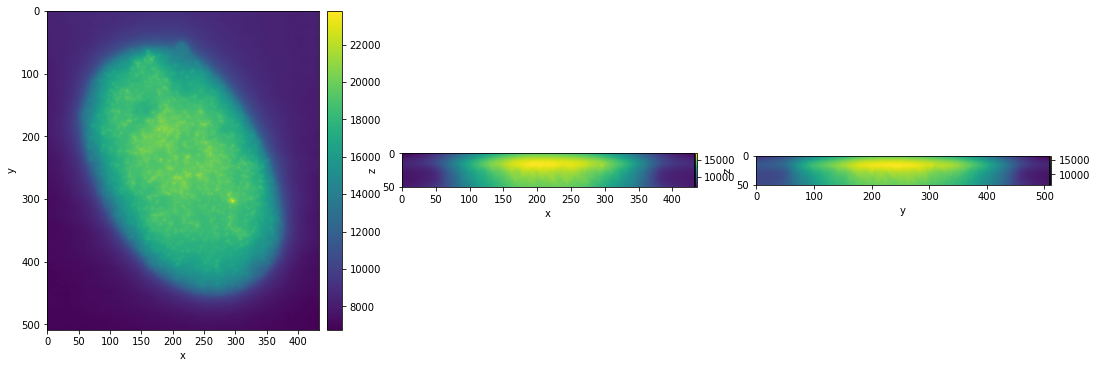

In [46]:
_ = plot_3d_projections(img_3d)

Plot a sample from our dataloader showing a slice from the input volume and from a simulated training volume

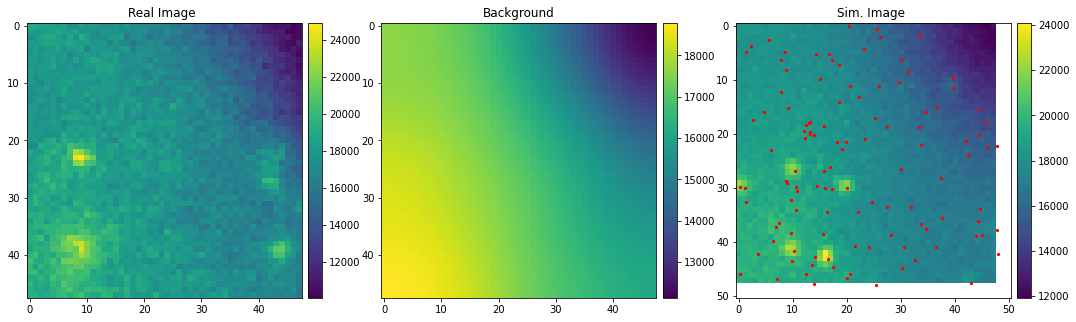

In [128]:
get_simulation_statistics(decode_dl, micro, int_threshold=10000)

Command to train a model on the gpu cluster

In [12]:
home_dir = os.getenv("HOME")
f'bsub -gpu "num=1" -q gpu_any -o {home_dir}/logs/ofish.log -e {home_dir}/logs/efish.log {home_dir}/anaconda3/envs/decode2_dev/bin/python {home_dir}/Mackebox/Artur/WorkDB/deepstorm/decode_fish/decode_fish/train.py +experiment={cfg.run_name}'

'bsub -gpu "num=1" -q gpu_any -o /groups/turaga/home/speisera/logs/ofish.log -e /groups/turaga/home/speisera/logs/efish.log /groups/turaga/home/speisera/anaconda3/envs/decode2_dev/bin/python /groups/turaga/home/speisera/Mackebox/Artur/WorkDB/deepstorm/decode_fish/decode_fish/train.py +experiment=N2_352_a8'

# Evaluation

In [493]:
cfg = OmegaConf.load(f'config/experiment/N2_352_17.yaml')
# exp_dir = 'N2_7/'
# cfg = OmegaConf.load('/groups/turaga/home/speisera/Mackebox/Artur/WorkDB/deepstorm/models/fishcod/N2_352/nb_run/N2_352_14/train.yaml')
cfg = OmegaConf.load('/groups/turaga/home/speisera/Mackebox/Artur/WorkDB/deepstorm/models/fishcod/N2_352/sweep_b3/psf_noise:0.0005xmultipl:55/train.yaml')
# cfg = OmegaConf.load('/groups/turaga/home/speisera/Mackebox/Artur/WorkDB/deepstorm/models/fishcod/N2_352/sweep_5/psf_noise:0/train.yaml')
# cfg = OmegaConf.load(f'/groups/turaga/home/speisera/Mackebox/Artur/WorkDB/deepstorm/models/fishcod/N2_352//autoencoder.lr:5e-05/train.yaml')
# cfg = OmegaConf.load(f'/groups/turaga/home/speisera/Mackebox/Artur/WorkDB/deepstorm/models/fishcod/N2_3/autoencoder.lr:5e-05/train.yaml')


In [494]:
model = hydra.utils.instantiate(cfg.model)
model = load_model_state(model, cfg.output.save_dir, 'model.pkl')
print(cfg.microscope.psf_noise)
cfg.microscope.psf_noise = 0
psf, noise, micro = load_psf_noise_micro(cfg)
psf.load_state_dict(torch.load(Path(cfg.output.save_dir)/'psf.pkl'))
post_proc = load_post_proc(cfg)
img_3d, decode_dl = get_dataloader(cfg)

# model = load_model_state(model, cfg.output.save_dir+'/sl_save', 'model.pkl')
# psf, noise, micro = load_psf_noise_micro(cfg)
# psf.load_state_dict(torch.load(Path(cfg.output.save_dir)/'sl_save'/'psf.pkl'))

0.0005


Plot projections of the PSF before and after optimizing it during training

array([<AxesSubplot:xlabel='x', ylabel='y'>,
       <AxesSubplot:xlabel='x', ylabel='z'>,
       <AxesSubplot:xlabel='y', ylabel='z'>], dtype=object)

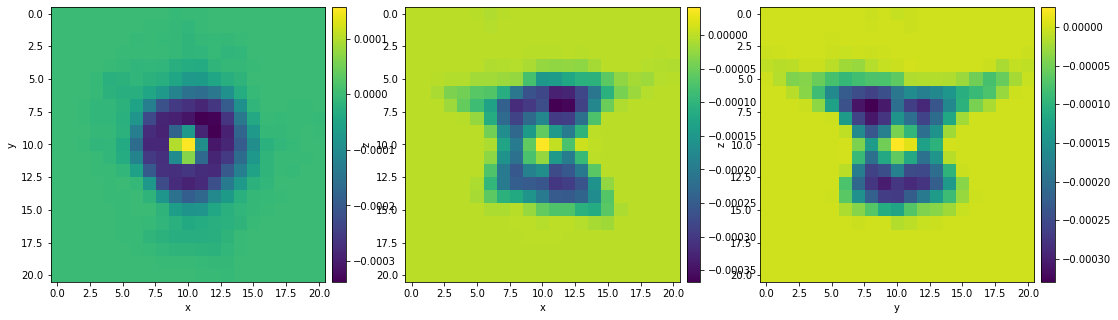

In [392]:
plot_3d_projections(psf_init.psf_volume[0]-psf.psf_volume[0])

Sample random sub volumes and overlay them with predictions, also show the reconstructions from applying the microscope and psf model to those predictions

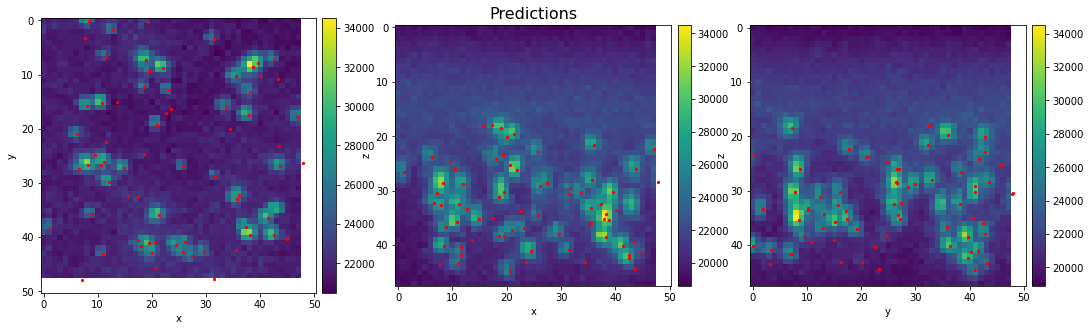

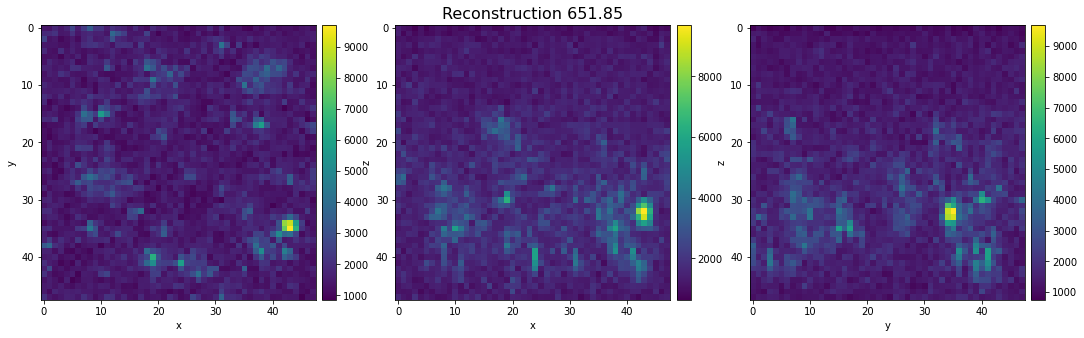

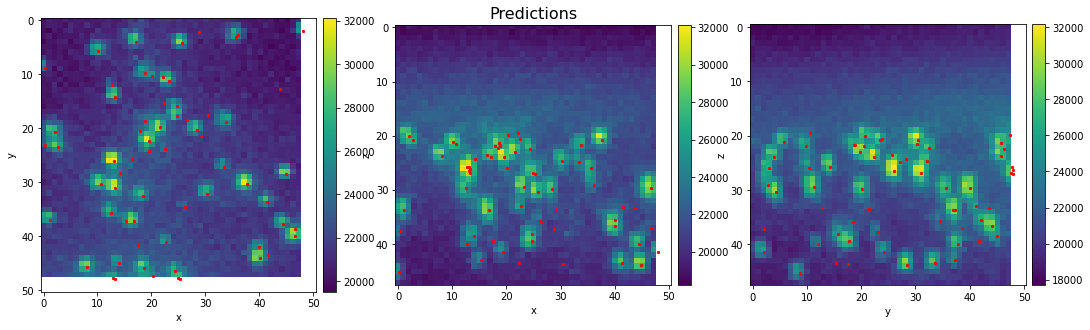

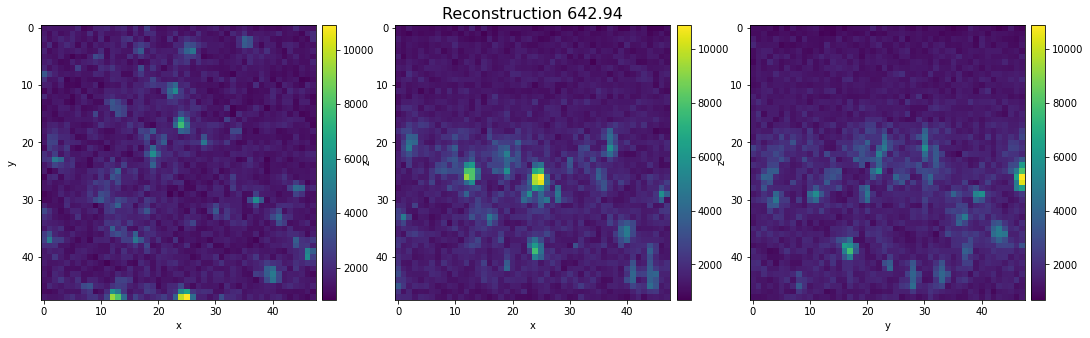

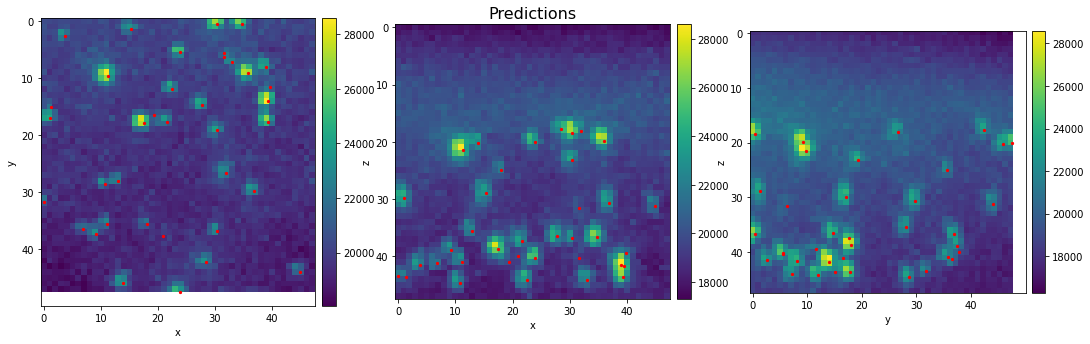

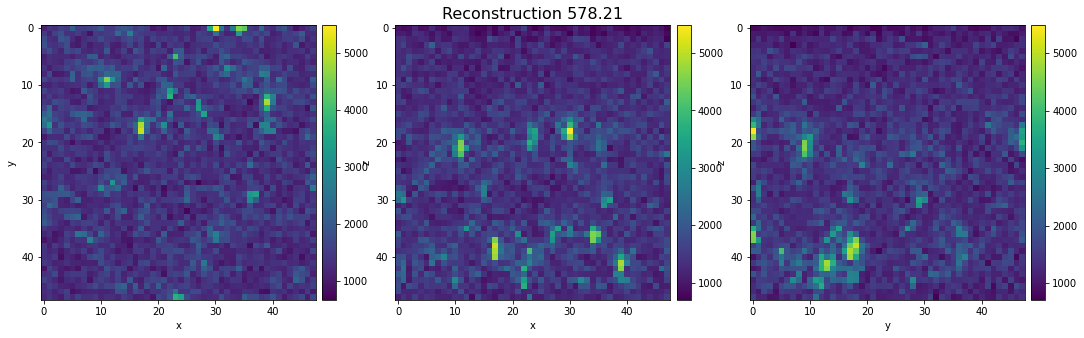

In [378]:
eval_random_crop(decode_dl, model, post_proc2, micro, projection='max', samples=3)

Volume with Foci? Max projection of real volume, reconstruction, difference

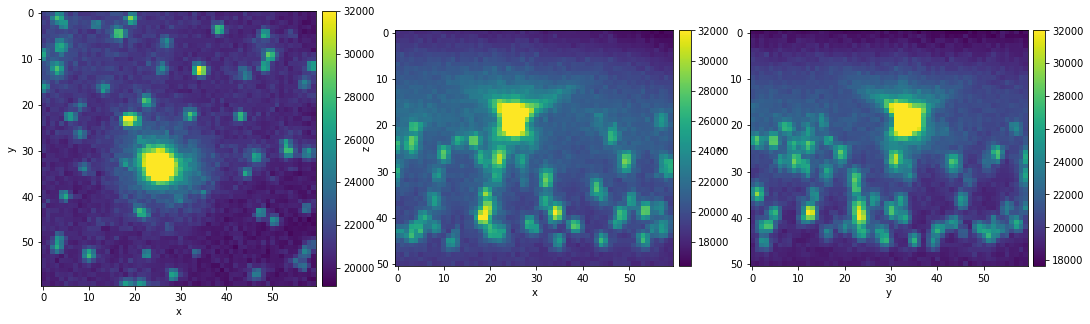

In [393]:
axes = plot_3d_projections(img_3d[:,270:330,270:330], 'max', vmax=32000)

101

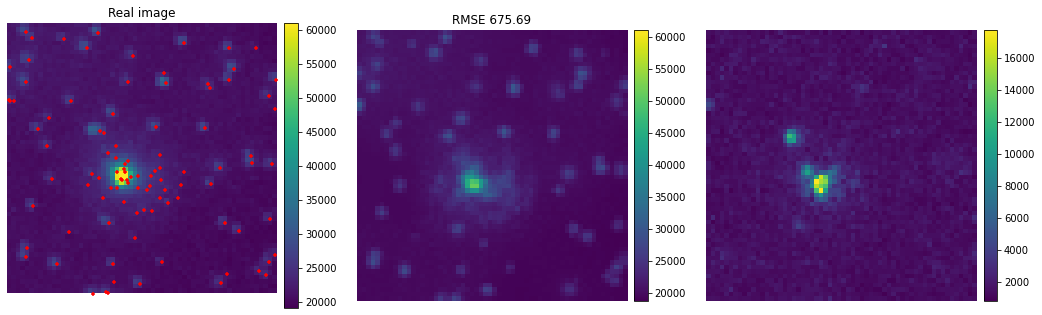

In [394]:
pred_df, gt_rec, res_dict = get_prediction(model,post_proc,img_3d[:,270:330,270:330], micro, return_rec=True, cuda=True)
axes = gt_plot(img_3d[:,270:330,270:330][None], pred_df, gt_df=None, px_size=[100,100,100], gt_rec=gt_rec[0])
torch.save(res_dict, 'data/model_output_r.pt')
len(pred_df)

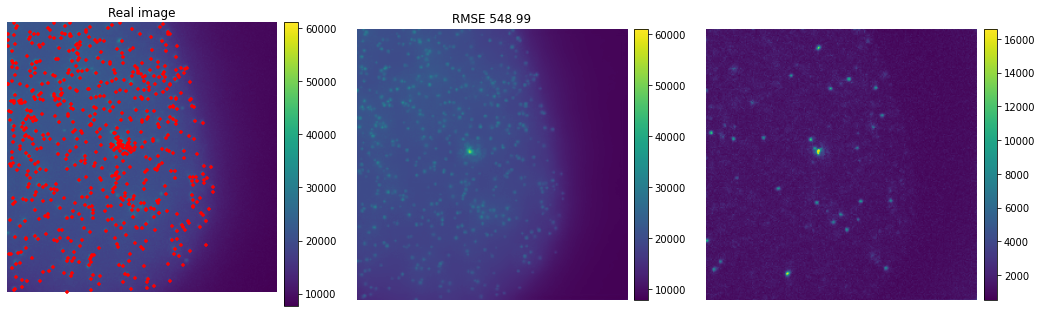

In [395]:
pred_df, gt_rec, _ = get_prediction(model,post_proc,img_3d[:,200:430,200:430], micro, return_rec=True, cuda=True)
_ = gt_plot(img_3d[:,200:430,200:430][None], pred_df, gt_df=None, px_size=[100,100,100], gt_rec=gt_rec[0])

In [418]:
cfg.prob_generator.high = 0.003
cfg.foci.n_foci_avg = 0
cfg.dataloader.bs=1
psf, noise, micro = load_psf_noise_micro(cfg)
psf.load_state_dict(torch.load(Path(cfg.output.save_dir)/'psf.pkl'))
img_3d, decode_dl = get_dataloader(cfg)

In [495]:
def sim_data(decode_dl, batches):
    
    gt_dfs = []
    xsim_col = []
    
    for _ in range(batches):
        x, local_rate, background = next(iter(decode_dl))
        sim_vars = PointProcessUniform(local_rate, min_int=decode_dl.min_int).sample()
        xsim = micro(*sim_vars)
        x = micro.noise(xsim, background).sample()
        
        xsim_col.append(x)
        gt_dfs.append(sample_to_df(*sim_vars[:-1]))
        
    return torch.cat(xsim_col), cat_emitter_dfs(gt_dfs)

def get_sim_perf(x, gt_df, model, post_proc, micro, cuda=True, print_res=True):

    pred_dfs = []
    x_recs = []
    
    for i in range(len(x)):
        
        pred_df, rec, res_dict = get_prediction(model, post_proc, x[i:i+1], micro=micro, cuda=True, return_rec=True)
        pred_dfs.append(pred_df)
        x_recs.append(rec)
        
    pred_df = cat_emitter_dfs(pred_dfs)
    xrec = torch.cat(x_recs)
    perf, matches, _ = matching(gt_df, pred_df, tolerance=500, print_res=print_res)
    perf['mae'] = abs(xrec-rec).mean().item()
    perf['rmse'] = torch.sqrt(((xrec-rec)**2).mean()).item()
    
    return perf, pred_df

In [501]:
xsim, gt = sim_data(decode_dl, 10)

In [502]:
perf, pred_df = get_sim_perf(xsim, gt, model, post_proc, micro, print_res=True)

Recall: 0.878
Precision: 0.995
Jaccard: 87.421
RMSE_vol: 41.119
Eff_3d: 75.898
FN: 383.0 FP: 14.0
Shift: -1.31,-0.42,0.50


In [503]:
len(pred_df)

2773

In [504]:
post_proc1 = SIPostProcess(m1_threshold=0.03, m2_threshold=0.5, samp_threshold=0.1, px_size=[100,100,100], diag=False)
post_proc2 = ISIPostProcess(m1_threshold=0.03, samp_threshold=0.5, px_size=[100,100,100], diag=True)

In [ ]:
p1_dicts = []
p2_dicts = []
p3_dicts = []

sweep = np.linspace(0.3,0.7,11)

for m in tqdm(sweep):
    post_proc1.m2_threshold = m
    p1_dicts.append(get_sim_perf(xsim, gt, model, post_proc1, micro, print_res=False)[0])
    
sweep = np.linspace(0.01,0.1,11)

for m in tqdm(sweep):
    post_proc2.m1_threshold = m
    p2_dicts.append(get_sim_perf(xsim, gt, model, post_proc2, micro, print_res=False)[0])
    
sweep = np.linspace(0.1,0.7,11)

for m in tqdm(sweep):
    post_proc2.samp_threshold = m
    p3_dicts.append(get_sim_perf(xsim, gt, model, post_proc2, micro, print_res=False)[0])

 18%|█▊        | 2/11 [00:29<02:10, 14.52s/it]

In [ ]:
# x,_,_ = next(iter(decode_dl))

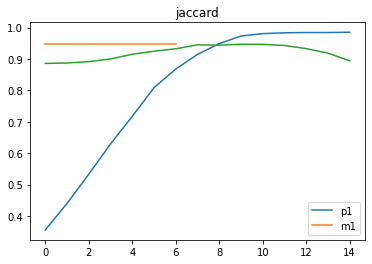

In [440]:
metrics = ['jaccard','eff_3d','mae','rmse']
for m in metrics:
    y = [d[m] for d in p1_dicts]
    plt.plot(y, label='p1')
    y = [d[m] for d in p2_dicts]
    plt.plot(y, label='m1')
    y = [d[m] for d in p3_dicts]
    plt.plot(y)
    plt.title(m)
#     plt.ylim(80,95)
    plt.legend()
    plt.show()

In [401]:
with torch.no_grad():
    model.cpu()
    res = model(img_3d[None,None])
#     res = model(x.cpu())
    pred_df1 = post_proc(res)
    free_mem()

Inferred intensities

2485 2485


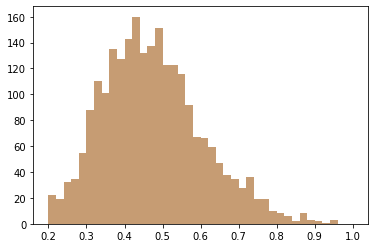

In [402]:
_ = plt.hist(pred_df1['int'], bins=np.linspace(0.2,1,41), alpha=0.5)
_ = plt.hist(pred_df2['int'], bins=np.linspace(0.2,1,41), alpha=0.5)
print(len(pred_df1),len(pred_df2))

In [259]:
def scatter3d_df(df, shape, px_size=[100,100,100], color='red', size=1):
    ipv.scatter(df['x']/px_size[0] - 1/2*shape[2], 
                df['y']/px_size[1] - 1/2*shape[1], 
                df['z']/px_size[2] - 1/2*shape[0], size=size, marker='sphere', color=color)

3D rendering

In [ ]:
vol = img_3d.numpy()

extent = [[-s/2,s/2] for s in vol.shape]
extent = [extent[i] for i in [2,1,0]]

ipv.figure()
ipv.pylab.volshow(vol, level=[.2,0.25,.1], opacity=[0.04,0.2,0.01], extent=extent)
scatter3d_df(pred_df, vol.shape, [100.,100.,300.], 'black', size=0.5)
ipv.xyzlim(max(vol.shape)/2)
ipv.view(90, 40)
ipv.show()